# Chapter 9 - [Support Vector Machines](http://scikit-learn.org/0.17/modules/svm.html#svm) 

- Classification, Regression에 모두 적용 가능 
- Feature 수가 많아도 잘 대응 (샘플수보다 feature수가 **많으면** 곤란) 
- 다양한 Kernel 함수를 사용해 분석할 데이터에 적합한 decision function 생성 
- ISLR 책 9장이 Support Vector Machine **개념**을 매우 친절하게 설명
- GridSearchCV와 RandomSearchCV를 사용해 hyper-parameter 탐색 공간을 자동적/체계적으로 탐색하고 그 결과를 활용하는 법을 익힘
- 'Heart' 데이터에 대해 Gradient Boosting과 SVM을 GridSearchCV/RandomSearchCV를 통해 적용한 결과를 해석/활용하는 예
- 1995년 [SVM](http://download.springer.com/static/pdf/467/art%253A10.1007%252FBF00994018.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Farticle%2F10.1007%2FBF00994018&token2=exp=1480068700~acl=%2Fstatic%2Fpdf%2F467%2Fart%25253A10.1007%25252FBF00994018.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Farticle%252F10.1007%252FBF00994018*~hmac=62be99775be16a4967ba228bf06a0d42cbddd5e1b022da8ace5fda29e2aa97d1) 논문 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.svm import SVC, NuSVC, LinearSVC, SVR 

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics  

%matplotlib inline
plt.style.use('seaborn-white')

## 9.6 Lab: Support Vector Machines
### [9.6.1 Support Vector Classifier](http://scikit-learn.org/0.17/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

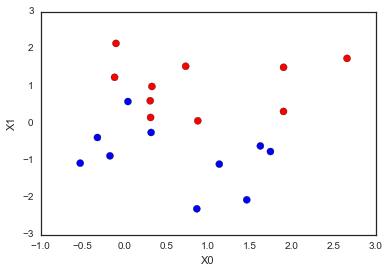

In [2]:
# 20 x 2 matrix 생성 : normal(0, 1) 분포, 카테고리 2개 (-1, 1)
np.random.seed(1)
X = np.random.randn(20,2)
y = np.repeat([-1,1], 10)

X[y == 1] = X[y == 1] +1
plt.scatter(X[:,0], X[:,1], s=50, c=y, cmap=plt.cm.bwr )  # cmap : matplotlib.org/examples/color/colormaps_reference.html
plt.xlabel('X0')
plt.ylabel('X1');

#### Classifier 2-D plotting function [참고1](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html), [참고2](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

In [3]:
from matplotlib.colors import ListedColormap

def plot_classifier(classifier, X, y, h=0.02, buffer=0.5):   # should be 2D feature space 

    # initialize custom marker and color-map : 쵀대 7개 class 까지 지원 
    markers = ('o', '^', 's', 'x', 'v', 'D', '*')
    colors = ('red', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    plt.figure(figsize=(8, 6))
    
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer
    y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Plot the decision boundary.
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot sample points
    for idx, cls in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cls, 0], y=X[y == cls, 1], alpha=0.9, c=cmap(idx), s=60,
                    marker=markers[idx], label=cls)
        
    plt.legend(loc='upper right', frameon=True, framealpha=0.3, borderaxespad=0.9)
    # additionally, support vectors have a white hole in a marker  
    if isinstance(classifier, (sklearn.svm.classes.SVC, SVC)):
        sv = classifier.support_vectors_
        plt.scatter(sv[:,0], sv[:,1], c='w', marker='.', s=40)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max) 
        
#         # plot the parallels to the separating hyperplane that pass through the support vectors
#         w = classifier.coef_[0]
#         a = -w[0] / w[1]
#         xx1 = np.linspace(-5, 5)
#         yy1 = a * xx1 - (classifier.intercept_[0]) / w[1]
        
#         margin = 1 / np.sqrt(np.sum(classifier.coef_ ** 2))
#         yy_down = yy1 + a * margin
#         yy_up = yy1 - a * margin
        
#         # plot the line, the points, and the nearest vectors to the plane
#         plt.plot(xx1, yy_down, 'k--')
#         plt.plot(xx1, yy_up, 'k--')
#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
                
        print('Number of Support Vectors (Class, SV) : ', list(zip(np.unique(y), classifier.n_support_)) )
    

Number of Support Vectors (Class, SV) :  [(-1, 3), (1, 3)]


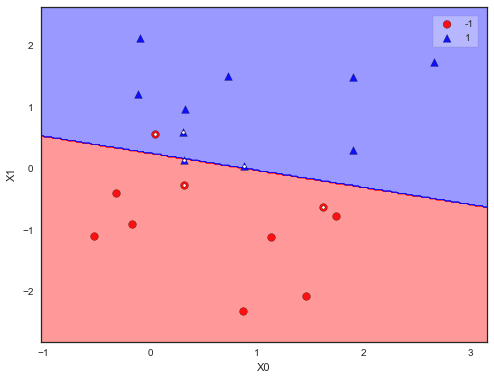

In [4]:
svc = SVC(C= 10, kernel='linear', probability=True)   # C: Penalty for the error. C higher -> narrower margin, less support vectors
svc.fit(X, y)
plot_classifier(svc, X, y)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

#### C값을 0.1로 낮춘다:
- scikit-learn의 C 값은 ISLR 책의 C와 반대 역할 (책에서의 C는 에러를 감내하는 허용치, scikit-learn에서의 C는 에러에 대한 벌칙)
- C가 0.1로 되어 training set 분류가 틀릴 가능성이 많아지더라도 margin이 커져 나중에 overfit 될 가능성을 낮춘다 

Number of Support Vectors (Class, SV) :  [(-1, 7), (1, 8)]


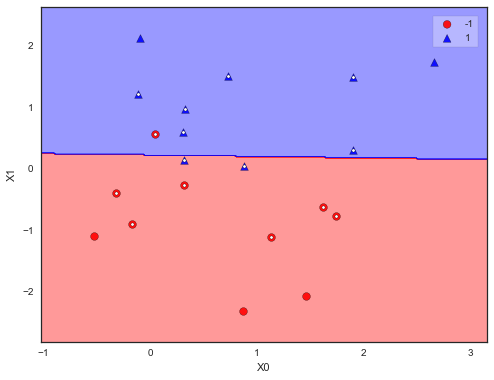

In [5]:
svc = SVC(C= 0.1, kernel='linear', probability=True)   # C : Penalty for the error. C higher -> smaller margin, less support vectors
svc.fit(X, y)
plot_classifier(svc, X, y)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

Cost (Penalty)를 10에서 0.1로 낮추니 margin이 커져 더 많은 misclassification을 허용하고, 따라서 support vector의 수가 늘어남 

In [6]:
print("Indices of support vectors:" , svc.support_ )
print()
print("Support Vectors:")
print(svc.support_vectors_)

Indices of support vectors: [ 0  3  4  6  7  8  9 11 12 13 14 15 16 17 18]

Support Vectors:
[[ 1.62434536 -0.61175641]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [-0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127]
 [-0.17242821 -0.87785842]
 [ 0.04221375  0.58281521]
 [ 1.90159072  1.50249434]
 [ 1.90085595  0.31627214]
 [ 0.87710977  0.06423057]
 [ 0.73211192  1.53035547]
 [ 0.30833925  0.60324647]
 [ 0.3128273   0.15479436]
 [ 0.32875387  0.9873354 ]
 [-0.11731035  1.2344157 ]]


In [7]:
print("Distance of the samples X to the separating hyperplane:\n%s" % svc.decision_function(X)  )

Distance of the samples X to the separating hyperplane:
[-0.61870697 -1.00940732 -1.92202839 -0.7306054  -0.36558981 -1.72706202
 -0.47991423 -1.00008067 -0.85410017  0.26457638  1.45409173  0.99991934
  0.09455529 -0.11621096  1.00016133  0.28495376 -0.05723407  0.57846584
  0.75902462  1.19637842]


#### training 성능: C=0.1 에서 

In [8]:
list(zip(y, svc.predict(X)))

[(-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, -1),
 (1, 1),
 (1, 1),
 (1, -1),
 (1, 1),
 (1, 1),
 (1, 1)]

앞의 plot에서 보았듯이 .-1' 클래스 중에는 1개, '1' 클래스에서는 2개를 잘 못 분류했다 

In [9]:
# C=0.1 시 confusion matrix, accuray 등 
conf_mat = metrics.confusion_matrix(y, svc.predict(X))     
print(conf_mat)

print("Accuracy: ", metrics.accuracy_score(y, svc.predict(X)) )
print("Sensitivity: ",  metrics.recall_score(y, svc.predict(X)) )
print("Precision: ",  metrics.precision_score(y, svc.predict(X)) )

y_pred_prob = svc.predict_proba(X)
print("AUC Score: ", metrics.roc_auc_score(y, y_pred_prob[:,1]) )

[[9 1]
 [2 8]]
Accuracy:  0.85
Sensitivity:  0.8
Precision:  0.888888888889
AUC Score:  0.97


#### Cross_Validation을 통한 모델 튜닝 : cost 'C'를 변경하면서, metric으로는  'accuracy'

In [10]:
range_C = list((0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100))
scores = []
for c in range_C:
    svc = SVC(C=c, kernel='linear', probability=False)   
    score_s = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    scores.append(np.mean(score_s))

list(zip(range_C, scores))

[(0.001, 0.94999999999999996),
 (0.01, 0.94999999999999996),
 (0.1, 0.84999999999999998),
 (0.5, 0.90000000000000002),
 (1, 0.90000000000000002),
 (5, 0.90000000000000002),
 (10, 0.90000000000000002),
 (100, 0.90000000000000002)]

C=0.001 경우가 가장 좋은 성능을 보임 

### [GridSearchCV](http://scikit-learn.org/stable/modules/grid_search.html#grid-search)
- Hyper parameter 공간을 Cross-Validation으로 탐색
- 넘겨진 모든 패러미터 조합을 완전히 탐색하여 최선의 조합을 반환 (Exhausitive Search) 
- param_grid : dict or list of dictionaries

#### 다음은 위 셀의 Cross-Validation을 통한 'C' 패러미터 탐색을 GridSearchCV로 행한 예:

In [11]:
from sklearn.grid_search import GridSearchCV

param_grid = [{'C': range_C, 'kernel': ['linear']}]   # parameter search space 
svc = SVC()
svc_GridCV = GridSearchCV(svc, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
svc_GridCV.fit(X, y)
svc_GridCV.grid_scores_              

[mean: 0.95000, std: 0.15000, params: {'kernel': 'linear', 'C': 0.001},
 mean: 0.95000, std: 0.15000, params: {'kernel': 'linear', 'C': 0.01},
 mean: 0.85000, std: 0.22913, params: {'kernel': 'linear', 'C': 0.1},
 mean: 0.90000, std: 0.20000, params: {'kernel': 'linear', 'C': 0.5},
 mean: 0.90000, std: 0.20000, params: {'kernel': 'linear', 'C': 1},
 mean: 0.90000, std: 0.20000, params: {'kernel': 'linear', 'C': 5},
 mean: 0.90000, std: 0.20000, params: {'kernel': 'linear', 'C': 10},
 mean: 0.90000, std: 0.20000, params: {'kernel': 'linear', 'C': 100}]

cross-validation 과 같은 결과를 보임 

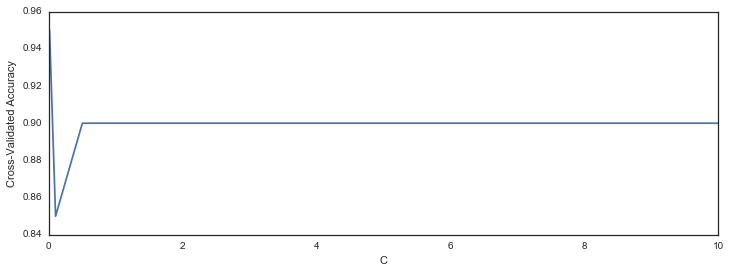

In [12]:
# plot the results
grid_mean_scores = [result.mean_validation_score for result in svc_GridCV.grid_scores_]
plt.figure(figsize=(12, 4))
plt.plot(range_C, grid_mean_scores)
plt.xlim([0, 10])
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')

In [13]:
print("Best Score:", svc_GridCV.best_score_)
print("Best Params:", svc_GridCV.best_params_)
print(svc_GridCV.best_estimator_)

Best Score: 0.95
Best Params: {'kernel': 'linear', 'C': 0.001}
SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


설정된 ***그리드 공간 내에서의***  최적 모델 : C=0.001 시 Accuracy 가 0.95라 함.  Kernel은 'linear' 한 가지로 세팅했음  

#### 위에서 구한 최적의 패러미터로 최적의 모델을 다시 만든다 

Number of Support Vectors (Class, SV) :  [(-1, 10), (1, 10)]


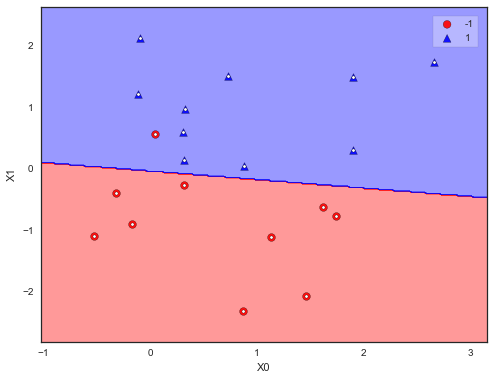

In [14]:
svc_best = SVC(C= 0.001, kernel='linear', probability=True)
svc_best.fit(X, y)
plot_classifier(svc_best, X, y)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

#### Test set을 만들어 앞에서 구한 최적의 모델로 시험해 본다 
- training set과 같이 대략 y=x 의 decision line이 생기도록 샘플들 배치 

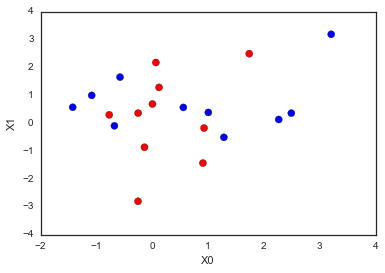

In [15]:
np.random.seed(123)
X_test = np.random.randn(20, 2)
y_test = np.random.choice([-1,1], 20, replace=True)

X_test[y_test == 1] = X_test[y_test == 1] +1
plt.scatter(X_test[:,0], X_test[:,1], s=50, c=y, cmap=plt.cm.bwr )  
plt.xlabel('X0')
plt.ylabel('X1')

- C=0.001을 사용해 training set으로 구한 hyperplane 모양과 위 test-sample 배치를 보니 test 성능이 좋을 것 같지 않다

#### grid search CV의 최적 패러미터 세팅(C=0.001) 값으로 test data에 적용한 결과:

In [16]:
pred_test = svc_best.predict(X_test)
# list(zip(y_test, pred_test))
conf_mat = metrics.confusion_matrix(y_test, pred_test)     
print(conf_mat)

print("Accuracy: ", metrics.accuracy_score(y_test, pred_test) )
print("Sensitivity: ",  metrics.recall_score(y_test, pred_test) )
print("Precision: ",  metrics.precision_score(y_test, pred_test) )

[[ 5  4]
 [ 1 10]]
Accuracy:  0.75
Sensitivity:  0.909090909091
Precision:  0.714285714286


#### GridSearchCV한 결과에 predict() 메소드를 적용하면 최적의 패러미터를 사용해 predict() 해 주기에 위 cell의 결과와 같은 결과를 반환

In [17]:
pred_grid = svc_GridCV.predict(X_test)       # prediction based on the best parameters via gridCV 
conf_mat = metrics.confusion_matrix(y_test, pred_grid)     
print(conf_mat)

print("Accuracy: ", metrics.accuracy_score(y_test, pred_grid) )
print("Sensitivity: ",  metrics.recall_score(y_test, pred_grid) )
print("Precision: ",  metrics.precision_score(y_test, pred_grid) )


[[ 5  4]
 [ 1 10]]
Accuracy:  0.75
Sensitivity:  0.909090909091
Precision:  0.714285714286


#### Linearly separable한 data에 SVC를 적용하면;
- 원래 X, y에서 y==1 인 X에 0.5를 더해 더욱 두 클래스간의 간격을 넓혀 linearly separable 하게 함  

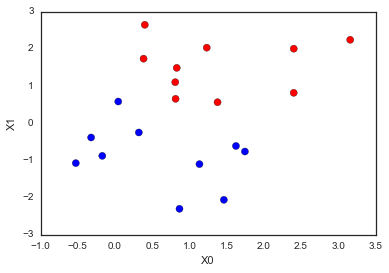

In [18]:
X_bak = X.copy()
y_bak = y.copy()

X[y==1] = X[y==1] + 0.5
plt.scatter(X[:,0], X[:,1], s=50, c=y, cmap=plt.cm.bwr )  # cmap : matplotlib.org/examples/color/colormaps_reference.html
plt.xlabel('X0')
plt.ylabel('X1');

보기에도 linearly separable 함 

#### SVC with C=100000

Number of Support Vectors (Class, SV) :  [(-1, 2), (1, 1)]


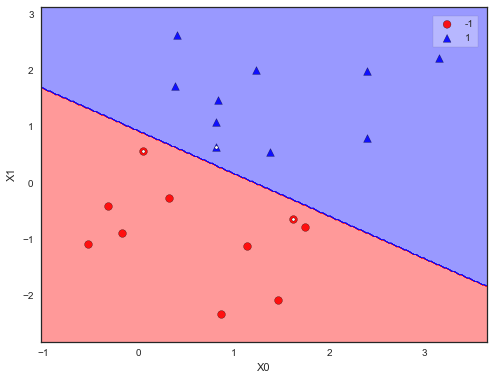

In [19]:
svc_C_big = SVC(C= 100000, kernel='linear', probability=True)  # default kernel 세팅은 rbf 임 
svc_C_big.fit(X, y)
plot_classifier(svc_C_big, X, y)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

In [20]:
conf_mat = metrics.confusion_matrix(y, svc_C_big.predict(X))     
print(conf_mat)

print("Accuracy: ", metrics.accuracy_score(y, svc_C_big.predict(X)) )
print("Sensitivity: ",  metrics.recall_score(y, svc_C_big.predict(X)) )
print("Precision: ",  metrics.precision_score(y, svc_C_big.predict(X)) )
y_pred_prob = svc_C_big.predict_proba(X)
print("AUC Score: ", metrics.roc_auc_score(y, y_pred_prob[:,1]) )
print("Number of support vectors: ", np.sum(svc_C_big.n_support_))

[[10  0]
 [ 0 10]]
Accuracy:  1.0
Sensitivity:  1.0
Precision:  1.0
AUC Score:  1.0
Number of support vectors:  3


- training set에 대한 것이긴 해도 완벽하게 분류함 
- support vector 3개로 margin이 좁음 

#### C값을 줄여 0.1로 하면 margin이 넓어져 out-of-sample 케이스에도 더 낫게 대처할 가능성 커짐 

Number of Support Vectors (Class, SV) :  [(-1, 6), (1, 6)]


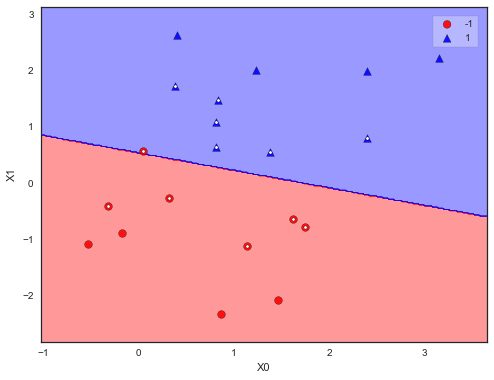

[[ 9  1]
 [ 0 10]]
Accuracy:  0.95
Sensitivity:  1.0
Precision:  0.909090909091
AUC Score:  1.0
Number of support vectors:  12


In [21]:
svc_C_small = SVC(C= 0.1, kernel='linear', probability=True)
svc_C_small.fit(X, y)
plot_classifier(svc_C_small, X, y)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

conf_mat = metrics.confusion_matrix(y, svc_C_small.predict(X))     
print(conf_mat)

print("Accuracy: ", metrics.accuracy_score(y, svc_C_small.predict(X)) )
print("Sensitivity: ",  metrics.recall_score(y, svc_C_small.predict(X)) )
print("Precision: ",  metrics.precision_score(y, svc_C_small.predict(X)) )
y_pred_prob = svc_C_small.predict_proba(X)
print("AUC Score: ", metrics.roc_auc_score(y, y_pred_prob[:,1]) )
print("Number of support vectors: ", np.sum(svc_C_small.n_support_))

### 9.6.2 Support Vector Machine [(예)](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#examples-using-sklearn-svm-svc) 
- [RBF 커널 세팅](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

#### 클래스가 2개이고(binary class) Linearly Separable 하지 않는 샘플을 만듬

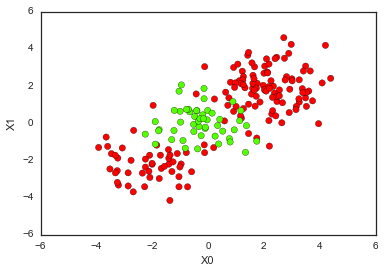

In [22]:
np.random.seed(123)
X = np.random.randn(200,2)
X[:100, :] = X[:100, :] + 2
X[100:150, :] = X[100:150, :] - 2
# y = np.repeat([1,2], [150, 50])   # has problem later on with ROC curve  
y = np.repeat([0,1], [150, 50])

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.prism )  
plt.xlabel('X0')
plt.ylabel('X1');

#### Radial Kernel을 이용해 모델 만들기 : training set을 이용하여 C=1, gamma=1

Number of Support Vectors (Class, SV) :  [(0, 29), (1, 16)]


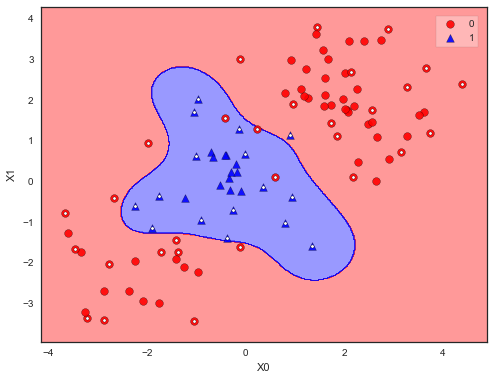

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, random_state=1234)  # train/test split 

rbf_svc = SVC(kernel='rbf', gamma=1, C=1.0).fit(X_train, y_train)  # Use the training set 
plot_classifier(rbf_svc, X_train, y_train)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

Training performance : 눈으로 보니 4개 샘플이 잘 못 분류됨 

In [24]:
conf_mat = metrics.confusion_matrix(y_train, rbf_svc.predict(X_train))     
print(conf_mat)
print("%d samples are mis-classified out of %d" % ((conf_mat[0,1]+conf_mat[1,0]), np.sum(conf_mat)) )

[[69  3]
 [ 1 27]]
4 samples are mis-classified out of 100


In [25]:
print("Indices of support vectors:" , rbf_svc.support_ )
print()
# print("Support Vectors:")
# print(rbf_svc.support_vectors_)

Indices of support vectors: [ 4  9 10 11 18 32 37 38 40 42 47 48 49 50 53 59 62 63 64 69 76 77 83 84 86
 87 92 94 97  0  1  2  8 23 26 28 34 35 41 54 60 88 89 91 95]



#### Increase C for narrower margin (complex fit) 

Number of Support Vectors (Class, SV) :  [(0, 20), (1, 10)]


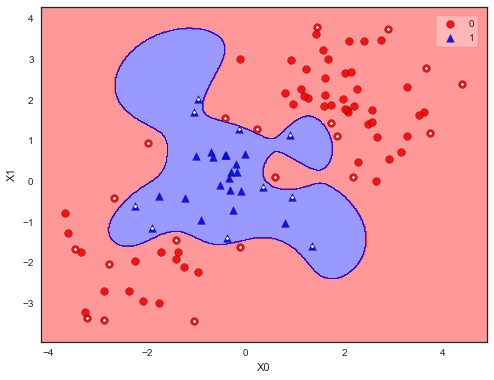

In [26]:
rbf_svc = SVC(kernel='rbf', gamma=1, C=1e5).fit(X_train, y_train)  # Use the training set 
plot_classifier(rbf_svc, X_train, y_train)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

In [27]:
metrics.confusion_matrix(y_train, rbf_svc.predict(X_train)) 

array([[72,  0],
       [ 0, 28]])

완벽함.  하지만 decision boundary가 지나치게 복잡해 overfitting 가능성 많음 

#### Grid Search를 이용해 RBF 커널을 사용하는 SVM의 C와 gamma를 변화시키면서 (공간내) 최적의 세팅을 탐색:
- 전체 데이터가 아닌 training set에 대해 수행 
- C와 gamma가 커질수록 complex 모델

In [28]:
parameters = [{'gamma': [0.5, 1, 2, 3, 4],
               'C': [0.01, 0.1, 1, 10, 100, 1000]}]
clf_grid = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10, scoring='accuracy')
clf_grid.fit(X_train, y_train)
clf_grid.grid_scores_

[mean: 0.72000, std: 0.03029, params: {'gamma': 0.5, 'C': 0.01},
 mean: 0.72000, std: 0.03029, params: {'gamma': 1, 'C': 0.01},
 mean: 0.72000, std: 0.03029, params: {'gamma': 2, 'C': 0.01},
 mean: 0.72000, std: 0.03029, params: {'gamma': 3, 'C': 0.01},
 mean: 0.72000, std: 0.03029, params: {'gamma': 4, 'C': 0.01},
 mean: 0.87000, std: 0.09559, params: {'gamma': 0.5, 'C': 0.1},
 mean: 0.81000, std: 0.07769, params: {'gamma': 1, 'C': 0.1},
 mean: 0.72000, std: 0.03029, params: {'gamma': 2, 'C': 0.1},
 mean: 0.72000, std: 0.03029, params: {'gamma': 3, 'C': 0.1},
 mean: 0.72000, std: 0.03029, params: {'gamma': 4, 'C': 0.1},
 mean: 0.88000, std: 0.11263, params: {'gamma': 0.5, 'C': 1},
 mean: 0.87000, std: 0.10578, params: {'gamma': 1, 'C': 1},
 mean: 0.86000, std: 0.09194, params: {'gamma': 2, 'C': 1},
 mean: 0.84000, std: 0.08841, params: {'gamma': 3, 'C': 1},
 mean: 0.84000, std: 0.09908, params: {'gamma': 4, 'C': 1},
 mean: 0.89000, std: 0.06791, params: {'gamma': 0.5, 'C': 10},
 mean:

In [29]:
# 최적 모델 보기 
print(clf_grid.best_score_)
print(clf_grid.best_params_)

0.9
{'gamma': 2, 'C': 10}


- C 가 커지고, gamma 가 커질 수록 non-linear 한 데이터를 잘 분류.  그러나 overfit 가능성도 증가 
- 같은 성능치를 보이면 C와 gamma가 작은 패러미터를 반환  
- 이 데이터에 대한 (탐색 공간내) 최적 RBF-SVM은 C=10, gamma=2.  이 때 accuracy=0.9 

Cross-validation이나 grid search CV를 사용해 모델을 만들때, 책에서와 같이 train/test split하고 **train set에** 대해 CV나 GridSearchCV를 적용해 적당한 패러미터를 선정하고, 이를 이용해 모델을 만들어 이 모델로 test set을 평가해 test performance를 추정하는 방법도 가능. 

#### GridSearchCV 가 반환한 최적 parameter 조합에 test performance 평가: 

In [30]:
y_pred_best = clf_grid.predict(X_test)    # y_pred_best = clf_grid.best_estimator_.predict(X_test) : does the same 

conf_mat = metrics.confusion_matrix(y_test, y_pred_best)      
print(conf_mat)

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_best) )
print("Sensitivity: ",  metrics.recall_score(y_test, y_pred_best) )
print("Precision: ",  metrics.precision_score(y_test, y_pred_best) )

[[68 10]
 [ 4 18]]
Accuracy:  0.86
Sensitivity:  0.818181818182
Precision:  0.642857142857


### 9.6.3 ROC Curves

4장에서 배운 ROC 커브의 특성을 복습. 
- Training set에 대해서는 non-linear 한 데이터도 잘 fit하는 복잡한(flexible) 모델이 더 좋은 성능을 보이지만,
- Test set에 대해서는 반드시 그렇지 않음.  
- SVM도 마찬가지. ROC 커브 특성에서도 나타남 

#### Training set으로 훈련한 두개의 rbf_svm 모델을 만들어 training set과 test set에 각각 적용해 본다. 
- svm_opt : 앞에서 gridSearchCV로 구한 최적 패러미터 사용 (C': 10, 'gamma': 2)
- svm_flex : svm_opt에서 gamma=100 으로 높여 모델을 non-linearity에 잘 적응시켜 flexible 하게 한 것 

In [31]:
svm_opt = SVC(kernel='rbf', C=10, gamma=2, probability=True)   # 최적 패러미터 기반 모델 
svm_opt.fit(X_train, y_train)

svm_flex = SVC(kernel='rbf', C=10, gamma=100, probability=True)   # gamma를 100으로 증가해 non-linear 특성 강화 모델 
svm_flex.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

auc_opt_train: 1.000 , auc_flex_train: 1.000
auc_opt_test: 0.885 , auc_flex_test: 0.859


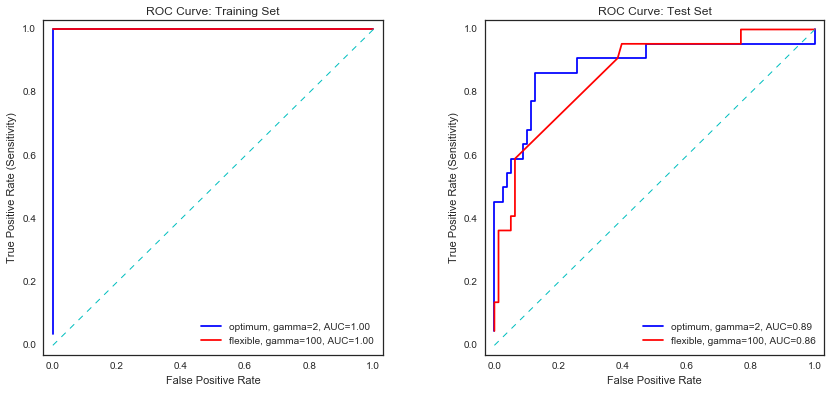

In [32]:
# ROC Curve : against training set
y_pred_prob_opt = svm_opt.predict_proba(X_train)
y_pred_prob_flex = svm_flex.predict_proba(X_train)

fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(y_train, y_pred_prob_opt[:,1])
fpr_flex, tpr_flex, thresholds_flex = metrics.roc_curve(y_train, y_pred_prob_flex[:,1])

auc_opt_train = metrics.roc_auc_score(y_train, y_pred_prob_opt[:,1])
auc_flex_train = metrics.roc_auc_score(y_train, y_pred_prob_flex[:,1])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))          
fig.subplots_adjust(wspace=0.3)

ax1.plot(fpr_opt, tpr_opt, color='b', label='optimum, gamma=2, AUC=%.2f' % auc_opt_train)
ax1.plot(fpr_flex, tpr_flex, color='r', label='flexible, gamma=100, AUC=%.2f' % auc_flex_train)
ax1.set_title('ROC Curve: Training Set')

print("auc_opt_train: %.3f , auc_flex_train: %.3f" % (auc_opt_train, auc_flex_train))

# ROC Curve : against Test set
y_pred_prob_opt = svm_opt.predict_proba(X_test)
y_pred_prob_flex = svm_flex.predict_proba(X_test)

fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(y_test, y_pred_prob_opt[:,1])
fpr_flex, tpr_flex, thresholds_flex = metrics.roc_curve(y_test, y_pred_prob_flex[:,1])

auc_opt_test = metrics.roc_auc_score(y_test, y_pred_prob_opt[:,1])
auc_flex_test = metrics.roc_auc_score(y_test, y_pred_prob_flex[:,1])

ax2.plot(fpr_opt, tpr_opt, color='b', label='optimum, gamma=2, AUC=%.2f' % auc_opt_test)
ax2.plot(fpr_flex, tpr_flex, color='r', label='flexible, gamma=100, AUC=%.2f' % auc_flex_test)
ax2.set_title('ROC Curve: Test Set')

print("auc_opt_test: %.3f , auc_flex_test: %.3f" % (auc_opt_test, auc_flex_test))

for ax in fig. axes:
    ax.plot([0, 1], [0, 1], 'c--', linewidth=1.0)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_ylim([-0.03, 1.03])
    ax.set_xlim([-0.03, 1.03])
    ax.legend(loc="lower right")
    
    

- Training set에 대해서는 두 모델이 다 완벽했지만, (optimum plot이 flexible plot에 가렸음) 
- Test set에 대해서는 CV로 구한 패러미터로 설정한 모델이 더 나은 ROC 커브를 보여준다. Classification의 결과를 확률로 받아 FPR이 0.18 즈음 되는 지점의 threshold로 판별을 고려  

### 9.6.4 SVM with Multiple Classes : Target response가 3개 이상의 클래스로 된 경우
- scikit-learn의 SVM은 One-Verses-One 방법으로 Multi-Class Classification 수행 [[참고]](http://scikit-learn.org/stable/modules/multiclass.html)

Generate data: There are simpler ways to do this.  But I followed exactly as written in the book

In [33]:
np.random.seed(123)
X = np.random.randn(200,2)
X[:100, :] = X[:100, :] + 2
X[100:150, :] = X[100:150, :] - 2
y = np.repeat([1,2], [150, 50])    

X = np.vstack((X, np.random.randn(50,2)))
y = np.concatenate((y, np.repeat(0, 50)), axis=0)

X[y==0, 1] = X[y==0, 1] + 3   # changed a little compared to ISLR because randomly generated data is different 

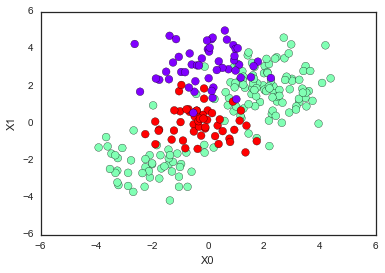

In [34]:
plt.scatter(X[:,0], X[:,1], s=60, c=y, cmap=plt.cm.rainbow )  
plt.xlabel('X0')
plt.ylabel('X1');

#### RBF Kernel, all data, C=10, gamma=1

Number of Support Vectors (Class, SV) :  [(0, 31), (1, 62), (2, 27)]


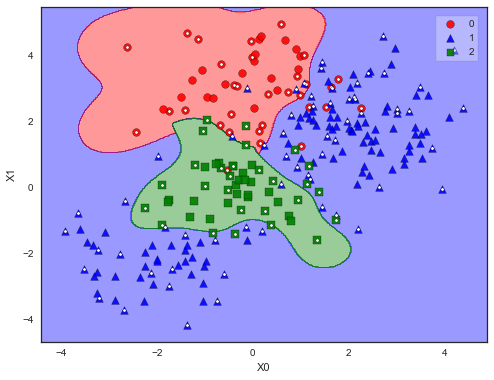

In [35]:
svm_multi_clf = SVC(kernel='rbf', C=10, gamma=1)
svm_multi_clf.fit(X,y)
plot_classifier(svm_multi_clf, X, y)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

#### Grid Search를 이용해 적당한 C와 gamma를 탐색 :¶

In [36]:
parameters = [{'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
               'C': [0.01, 0.1, 0.5, 1, 5, 10, 100, 1000]}]
svm_multi_clf_grid = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10, scoring='accuracy')
svm_multi_clf_grid.fit(X, y)
svm_multi_clf_grid.grid_scores_

# 최적 모델 보기 (accuracy 기준)
print(svm_multi_clf_grid.best_score_)
print(svm_multi_clf_grid.best_params_)

0.868
{'gamma': 0.1, 'C': 1}


Number of Support Vectors (Class, SV) :  [(0, 28), (1, 50), (2, 34)]


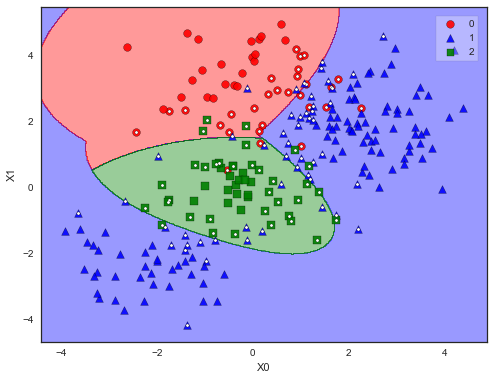

In [37]:
# Applying best parameter against training data 
svm_multi_clf = SVC(kernel='rbf', C=1, gamma=0.1)
svm_multi_clf.fit(X,y)
plot_classifier(svm_multi_clf, X, y)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

### 9.6.5 Application to Gene Expression Data
**Data**: Khan Gene Data

The data consists of a number of tissue samples corresponding to four distinct types of small round blue cell tumors. For each tissue sample, 2308 gene expression measurements are available.
- xtrain, xtest, ytrain, ytest 네 가지로 되어있음
- xtrain : numeric [1:63, 1:2308] 으로 63개 샘플, 2308개의 column
- ytrain : 63 element vector로 [1,2,3,4] 값을 가짐. 
- xtest : numeric [1:20, 1:2308] 으로 20개 샘플, 2308개의 column
- ytest : 20 element vector로 [1,2,3,4] 값을 가짐. 
데이터 샘플에 비해 feature수가 훨씬 많음. 

#### 목표: feature들로 부터 4가지 암 중 어디에 속하는 가를 추정하는 multiple-class Classification

In [38]:
# Data Loading & Munging
X_train = pd.read_csv('../Data/Khan_xtrain.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('../Data/Khan_ytrain.csv').drop('Unnamed: 0', axis=1).as_matrix().ravel()
X_test = pd.read_csv('../Data/Khan_xtest.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('../Data/Khan_ytest.csv').drop('Unnamed: 0', axis=1).as_matrix().ravel()

In [39]:
pd.Series(y_train).value_counts(sort=False)  # y_train table

1     8
2    23
3    12
4    20
dtype: int64

In [40]:
pd.Series(y_test).value_counts(sort=False)   # y_test table

1    3
2    6
3    6
4    5
dtype: int64

In [41]:
svc = SVC(kernel='linear', C=10)
svc.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Training set Confusion Matrix and Performance

In [42]:
pred_train = svc.predict(X_train)

print("Training Accuracy: ", metrics.accuracy_score(y_train, pred_train) )
print("Training Sensitivity: ",  metrics.recall_score(y_train, pred_train, average='weighted') )
print("Training Precision: ",  metrics.precision_score(y_train, pred_train, average='weighted') )
conf_mat = metrics.confusion_matrix(y_train, pred_train) ; conf_mat

Training Accuracy:  1.0
Training Sensitivity:  1.0
Training Precision:  1.0


array([[ 8,  0,  0,  0],
       [ 0, 23,  0,  0],
       [ 0,  0, 12,  0],
       [ 0,  0,  0, 20]])

#### Test set Confusion Matrix and Performance

In [43]:
pred_test = svc.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test, pred_test) 
conf_mat_df = pd.DataFrame(conf_mat, index=svc.classes_, columns=svc.classes_)
conf_mat_df.index.name = "True(실제)"
conf_mat_df.columns.name = "Predicted"
print(conf_mat_df)
print()
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred_test) )
print("Test Sensitivity: ",  metrics.recall_score(y_test, pred_test, average='weighted') )
print("Test Precision: ",  metrics.precision_score(y_test, pred_test, average='weighted') )

Predicted  1  2  3  4
True(실제)             
1          3  0  0  0
2          0  6  0  0
3          0  2  4  0
4          0  0  0  5

Test Accuracy:  0.9
Test Sensitivity:  0.9
Test Precision:  0.925


#### GridSearchCV - linear kernel

In [44]:
parameters = [{'C': [0.01, 0.1, 0.5, 1, 5, 10, 100, 1000]}]
svm_multi_clf_grid = GridSearchCV(SVC(kernel='linear'), parameters, cv=8, scoring='accuracy')
svm_multi_clf_grid.fit(X_train, y_train)
svm_multi_clf_grid.grid_scores_

# 최적 모델 보기 (accuracy 기준)
print(svm_multi_clf_grid.best_score_)
print(svm_multi_clf_grid.best_params_)

1.0
{'C': 0.01}


In [45]:
svc_best = SVC(kernel='linear', C=0.01)
svc_best.fit(X_train, y_train)

pred_test = svc_best.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test, pred_test) 
conf_mat_df = pd.DataFrame(conf_mat, index=svc.classes_, columns=svc.classes_)
conf_mat_df.index.name = "True(실제)"
conf_mat_df.columns.name = "Predicted"
print(conf_mat_df)
print()
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred_test) )
print("Test Sensitivity: ",  metrics.recall_score(y_test, pred_test, average='weighted') )
print("Test Precision: ",  metrics.precision_score(y_test, pred_test, average='weighted') )

Predicted  1  2  3  4
True(실제)             
1          3  0  0  0
2          0  6  0  0
3          0  2  4  0
4          0  0  0  5

Test Accuracy:  0.9
Test Sensitivity:  0.9
Test Precision:  0.925


-> 이 전 결과와 같음 

## Gradient Boosting Classifier와 Support Vector Classifier에 grid search CV를 적용해 최적 모델 만들기 및 두 모델 비교 - 'Heart' 데이터를 대상으로

#### 예측분석 진행: Heart 데이터 사용 심장병 진단
- Qualitative variable **'AHD'** is the response 
- 병 진단이기에 metric으로 단순 accuracy가 중요한 것이 아니라, sensitivity 및 FPR이 중요
- 따라서 AUC도 참고해, 적정한 패러미터를 선정하고 모델을 만들어 
- ROC를 보면서 threshold를 결정하여 
- classification 확률로 받은 결과에 threshold를 적용하여 최종적으로 classification을 수행한다. 
- GridSearchCV를 적절하게 사용한다. 

#### Let's begin: Load 'Heart' data, drop null rows, do label encoding of AHD, (No: 0,  Yes: 1)

In [46]:
Heart = pd.read_csv('../Data/Heart.csv', index_col=0).dropna()

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Heart.ChestPain = le.fit_transform(Heart.ChestPain)
Heart.Thal = le.fit_transform(Heart.Thal)
Heart.AHD = le.fit_transform(Heart.AHD)

X = Heart.drop('AHD', axis=1)
y = Heart.AHD    # No: 0,  Yes: 1

# 데이터 점검 
X.info()
y.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 1 to 302
Data columns (total 13 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null int32
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null int32
dtypes: float64(2), int32(2), int64(9)
memory usage: 30.2 KB


0    160
1    137
Name: AHD, dtype: int64

-> OK.  No nulls,  All Numeric,  No class imbalance

Standardization 같은 전처리 안 함 

### 1. Gradient Boosting Classifier 에 Grid Search CV 적용하면서 최적 모델 구하기 

In [47]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.utils import shuffle

tree_number = list(range(50, 251, 10))   

X, y = shuffle(X, y, random_state=123)   # Let's shuffle before going into gridSearchCV

param_grid = [{'n_estimators': tree_number, 'max_depth': [2, 3, 4]}] # grid 탐색 공간 

GB_clf = GradientBoostingClassifier(min_samples_split=1, max_features = 'sqrt', subsample = 0.9,
                                         learning_rate=0.02, loss='exponential', random_state=123)

GB_clf_gridCV_accuracy = GridSearchCV(GB_clf, param_grid, cv=7, scoring='accuracy', n_jobs=-1)
GB_clf_gridCV_AUC = GridSearchCV(GB_clf, param_grid, cv=7, scoring='roc_auc', n_jobs=-1)

GB_clf_gridCV_accuracy.fit(X, y)
GB_clf_gridCV_AUC.fit(X, y)

print("Accuracy Best Score:", GB_clf_gridCV_accuracy.best_score_)
print("Accuracy Best Params:", GB_clf_gridCV_accuracy.best_params_)
print(GB_clf_gridCV_accuracy.best_estimator_)

print()

print("AUC Best Score:", GB_clf_gridCV_AUC.best_score_)
print("AUC Best Params:", GB_clf_gridCV_AUC.best_params_)
print(GB_clf_gridCV_AUC.best_estimator_)


Accuracy Best Score: 0.845117845118
Accuracy Best Params: {'n_estimators': 90, 'max_depth': 2}
GradientBoostingClassifier(init=None, learning_rate=0.02, loss='exponential',
              max_depth=2, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=1,
              min_weight_fraction_leaf=0.0, n_estimators=90,
              presort='auto', random_state=123, subsample=0.9, verbose=0,
              warm_start=False)

AUC Best Score: 0.915117824105
AUC Best Params: {'n_estimators': 140, 'max_depth': 2}
GradientBoostingClassifier(init=None, learning_rate=0.02, loss='exponential',
              max_depth=2, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=1,
              min_weight_fraction_leaf=0.0, n_estimators=140,
              presort='auto', random_state=123, subsample=0.9, verbose=0,
              warm_start=False)


#### -> 잘 되었음.  두 metric이 다 비슷한 hyper parameter들을 추천. 

#### n_estimators=90~140, max_depth=2 으로 탐색공간 좁혀 다시 gridSearchCV 

In [48]:
tree_number = list(range(90, 141, 5) )  

X, y = shuffle(X, y, random_state=123)   # Let's shuffle before going into gridSearchCV

param_grid = [{'n_estimators': tree_number, 'max_depth': [2]}] # grid 탐색 공간 

GB_clf = GradientBoostingClassifier(min_samples_split=1, max_features = 'sqrt', subsample = 0.9,
                                         learning_rate=0.02, loss='exponential', random_state=123)

GB_clf_gridCV_accuracy = GridSearchCV(GB_clf, param_grid, cv=7, scoring='accuracy', n_jobs=-1)
GB_clf_gridCV_AUC = GridSearchCV(GB_clf, param_grid, cv=7, scoring='roc_auc', n_jobs=-1)

GB_clf_gridCV_accuracy.fit(X, y)
GB_clf_gridCV_AUC.fit(X, y)

print("Accuracy Best Score:", GB_clf_gridCV_accuracy.best_score_)
print("Accuracy Best Params:", GB_clf_gridCV_accuracy.best_params_)
print(GB_clf_gridCV_accuracy.best_estimator_)

print()

print("AUC Best Score:", GB_clf_gridCV_AUC.best_score_)
print("AUC Best Params:", GB_clf_gridCV_AUC.best_params_)
print(GB_clf_gridCV_AUC.best_estimator_)


Accuracy Best Score: 0.841750841751
Accuracy Best Params: {'n_estimators': 90, 'max_depth': 2}
GradientBoostingClassifier(init=None, learning_rate=0.02, loss='exponential',
              max_depth=2, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=1,
              min_weight_fraction_leaf=0.0, n_estimators=90,
              presort='auto', random_state=123, subsample=0.9, verbose=0,
              warm_start=False)

AUC Best Score: 0.92098682547
AUC Best Params: {'n_estimators': 95, 'max_depth': 2}
GradientBoostingClassifier(init=None, learning_rate=0.02, loss='exponential',
              max_depth=2, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=1,
              min_weight_fraction_leaf=0.0, n_estimators=95,
              presort='auto', random_state=123, subsample=0.9, verbose=0,
              warm_start=False)


**n_estimators = 95, max_depth = 2 로 최적의 Grandient Booosting Classifier 결정**

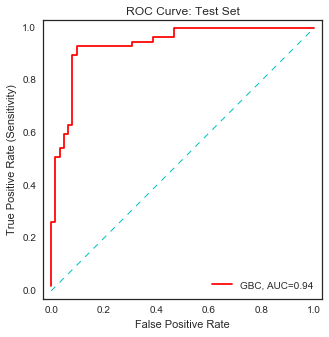

In [49]:
GB_clf_best = GradientBoostingClassifier(n_estimators=95, max_depth=2, min_samples_split=1, max_features = 'sqrt', subsample = 0.9,
                                         learning_rate=0.02, loss='exponential', random_state=123)

# Train/test split 하여 GB_clf_best를 train에 훈련시키고, test에 대해서 ROC plot 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=123) 

GB_clf_best.fit(X_train, y_train)
y_pred_prob = GB_clf_best.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1])

auc_test = metrics.roc_auc_score(y_test, y_pred_prob[:,1])

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='r', label='GBC, AUC=%.2f' % auc_test)
plt.title('ROC Curve: Test Set')
plt.plot([0, 1], [0, 1], 'c--', linewidth=1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.ylim([-0.03, 1.03])
plt.xlim([-0.03, 1.03])
plt.legend(loc="lower right")

ROC를 보면서 적절한 threshold 값 선택   

In [50]:
def get_TPR_FPR_given_Thd(threshold):   # return (sensitivity, FPR) tuple
    sensitivity_th = tpr[thresholds > threshold][-1]  
    fpr_th = fpr[thresholds > threshold][-1]
    return (sensitivity_th, fpr_th)

def get_Threshold_given_TPR(sensitivity):
    return (thresholds[tpr<sensitivity][-1] )

print(get_Threshold_given_TPR(0.9))
get_TPR_FPR_given_Thd(0.43)

0.432448516002


(0.89473684210526316, 0.096774193548387094)

-> Threshold를 0.44~0.42 사이에서 선택함이 좋겠음 : Sensitivity는 0.9 (탐지율 90%)에 달하고, FPR (병이 아닌데 병이라고 진단)은 0.1 (10%) 정도로 퍽 만족스럼 

### Gradient Boosting Classifier의 최종 스펙
- GB_clf_best 로 정함 (n_estimators = 95, max_depth = 2 ,,, )
- GB_clf_best 의 classifying 확률에 threshold를 0.43 정도에서 적용하면 **Test Set에 대해** Accuracy=0.85, TPR=0.9, FPR=0.1 정도를 기대할 수 있겠음 

#### 정말 그럴까 확인

In [51]:
y_pred_th = [1 if prob>0.43 else 0 for prob in y_pred_prob[:,1]]
conf_mat = metrics.confusion_matrix(y_test, y_pred_th) 
print(conf_mat)
TP = conf_mat[1,1]
TN = conf_mat[0,0]
FP = conf_mat[0,1]
FN = conf_mat[1,0]
print("\nAccuracy: %.2f" % ( (TP+TN) / (TP+TN+FP+FN)) )
print("Sensitivity(Recall): %.2f" %  (TP / (FN + TP)) )
print("Precision: %.2f" %  (TP / (FP + TP)) )
print("False Positive Rate: %.2f" %  (FP / (FP + TN)) )      

[[56  6]
 [ 6 51]]

Accuracy: 0.90
Sensitivity(Recall): 0.89
Precision: 0.89
False Positive Rate: 0.10


**OK. 꽤 괜찮은 모델 같음.  특히 FPR이 0.1 정도에서 억제됨이 좋음**  

### 2. Support Vector Machine 에 Grid Search CV 및 [Randomized Search CV](http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search) 적용하여 최적 모델 구하기 
- 패러미터를 추가해 GridSearchCV를 돌렸는데 탐색공간이 급격히 커진 때문인지 언제 계산이 끝날 지 몰라 당혹스러울 때가 많다. 이런 일들이 자주 일어남 
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) 는 exhaustive search (완전 검색) 이기에 패러미터가 추가되면 순식간에 연산 시간이 폭증할 수 있음. 이 경우 탐색공간의 일부 부분집합만 무작위 탐색하는 [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)를 동원 가능  
- 앞의 Gradient Boosting Classifier 경우와 비슷하게 진행
- Heart 데이터는 샘플수가 꽤 되므로 RBF와 Polynomial도 Kernel로 적용해 봄 
- SVM이 scale invariant 모델이 아니기에 일부 feature들을 standardization이나 MinMax [전처리](http://scikit-learn.org/stable/modules/preprocessing.html) 할 수도 있다. 

#### GridSearchCV: 꽤 시간 걸림 

In [52]:
# X_bak = X.copy()   
# y_bak = y.copy()

# # param_grid = [{'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100],
# #                'kernel': ['linear', 'rbf', 'poly'],
# #                'gamma': [0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10],
# #                'degree': [2,3,4]}
# #              ]

# param_grid = [{'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100],
#                'kernel': ['linear', 'rbf'],
#                'gamma': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50]}
#              ] 
               
# svc = SVC()
# SVM_clf_gridCV_accuracy = GridSearchCV(svc, param_grid, cv=7, scoring='accuracy', n_jobs=-1)
# SVM_clf_gridCV_AUC = GridSearchCV(svc, param_grid, cv=7, scoring='roc_auc', n_jobs=-1)

# SVM_clf_gridCV_accuracy.fit(X, y)
# SVM_clf_gridCV_AUC.fit(X, y)

# print("Accuracy Best Score:", SVM_clf_gridCV_accuracy.best_score_)
# print("Accuracy Best Params:", SVM_clf_gridCV_accuracy.best_params_)
# print(SVM_clf_gridCV_accuracy.best_estimator_)

# print()

# print("AUC Best Score:", SVM_clf_gridCV_AUC.best_score_)
# print("AUC Best Params:", SVM_clf_gridCV_AUC.best_params_)
# print(SVM_clf_gridCV_AUC.best_estimator_)

### 계산 시간(비용)을 줄이기 위해 [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)
- param_distributions : dict

아래 cell은 위 cell의 결과를 카피한 내용.  위 cell 실행에 일반 PC에서 20분 넘게 걸릴 수 있음.  comment-out된 parameter space를 grid search CV로 수행하면 하루가 다 갈수도  

#### Randomized Search CV는 random하게 parameter space의 일부 subset을 탐색함. 얼마나 꼼꼼이 탐색할지는 **'n_iter'** 로 결정함   

#### 앞의 gridsearchCV를 [randomized search CV](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.RandomizedSearchCV.html#sklearn.grid_search.RandomizedSearchCV)로 

In [53]:
from sklearn.grid_search import RandomizedSearchCV   # scikit-learn 0.17 버젼 

param_dist = {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100],    # dict 이어야 함 
               'kernel': ['linear', 'rbf'],
               'gamma': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50]}
                          
svc = SVC()
SVM_clf_randCV_accuracy = RandomizedSearchCV(svc, param_dist, cv=7, scoring='accuracy', 
                                             n_iter=20, n_jobs=-1)       # n_iter=20
SVM_clf_randCV_AUC = RandomizedSearchCV(svc, param_dist, cv=7, scoring='roc_auc', 
                                        n_iter=20, n_jobs=-1)            # n_iter=20

SVM_clf_randCV_accuracy.fit(X, y)
SVM_clf_randCV_AUC.fit(X, y)

print("Accuracy Best Score:", SVM_clf_randCV_accuracy.best_score_)
print("Accuracy Best Params:", SVM_clf_randCV_accuracy.best_params_)
print(SVM_clf_randCV_accuracy.best_estimator_)

print()

print("AUC Best Score:", SVM_clf_randCV_AUC.best_score_)
print("AUC Best Params:", SVM_clf_randCV_AUC.best_params_)
print(SVM_clf_randCV_AUC.best_estimator_)

Accuracy Best Score: 0.83164983165
Accuracy Best Params: {'kernel': 'linear', 'gamma': 10, 'C': 5}
SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

AUC Best Score: 0.906080988794
AUC Best Params: {'kernel': 'linear', 'gamma': 5, 'C': 0.1}
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


- 탐색 공간의 일부만 시험했지만, GridSearchCV 와 같거나 비슷한 Accuracy와 AUC 성능치를 보이는 패러미터를 찾았음
- RandomizedSearchCV로 찾은 패러미터는 물론 GridSearchCV 것과 다를 수 있음 

#### 20번 돌 때 어떤 패러미터들을 random하게 선택했고, 그 때 AUC는 어떤지 보자

In [54]:
SVM_clf_randCV_AUC.grid_scores_

[mean: 0.50000, std: 0.00000, params: {'kernel': 'rbf', 'gamma': 1, 'C': 10},
 mean: 0.88499, std: 0.03599, params: {'kernel': 'linear', 'gamma': 0.5, 'C': 0.01},
 mean: 0.90358, std: 0.03075, params: {'kernel': 'linear', 'gamma': 10, 'C': 0.5},
 mean: 0.50000, std: 0.00000, params: {'kernel': 'rbf', 'gamma': 5, 'C': 0.001},
 mean: 0.58293, std: 0.08079, params: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1},
 mean: 0.90608, std: 0.02907, params: {'kernel': 'linear', 'gamma': 5, 'C': 0.1},
 mean: 0.51951, std: 0.01941, params: {'kernel': 'rbf', 'gamma': 0.5, 'C': 0.01},
 mean: 0.90169, std: 0.02662, params: {'kernel': 'linear', 'gamma': 0.1, 'C': 10},
 mean: 0.90358, std: 0.03075, params: {'kernel': 'linear', 'gamma': 1, 'C': 0.5},
 mean: 0.88499, std: 0.03599, params: {'kernel': 'linear', 'gamma': 1, 'C': 0.01},
 mean: 0.63171, std: 0.07301, params: {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.01},
 mean: 0.90608, std: 0.02907, params: {'kernel': 'linear', 'gamma': 50, 'C': 0.1},
 mean: 0.90608, 

- rbf 커널이 나쁜 결과를 보였다
- {'kernel': 'linear', 'gamma': 5, 'C': 0.1} 패러미터 조합이 AUC=0.90608 로 가장 좋지만, 이와 비슷한 결과를 보이는 다른 패러미터 조합들도 많다 

#### 똑 같은 패러미터 공간인데, feature들이 standardization 된 상태라면?

In [55]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X)   # Feature X를 standardization 

param_dist = {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100],    # dict 이어야 함 
               'kernel': ['linear', 'rbf'],
               'gamma': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50]}
               
svc = SVC()
SVM_clf_randCV_accuracy = RandomizedSearchCV(svc, param_dist, cv=7, scoring='accuracy', 
                                             n_iter=20, n_jobs=-1)       
SVM_clf_randCV_AUC = RandomizedSearchCV(svc, param_dist, cv=7, scoring='roc_auc', 
                                        n_iter=20, n_jobs=-1)            

SVM_clf_randCV_accuracy.fit(X_scaled, y)
SVM_clf_randCV_AUC.fit(X_scaled, y)

print("Accuracy Best Score:", SVM_clf_randCV_accuracy.best_score_)
print("Accuracy Best Params:", SVM_clf_randCV_accuracy.best_params_)
print(SVM_clf_randCV_accuracy.best_estimator_)

print()

print("AUC Best Score:", SVM_clf_randCV_AUC.best_score_)
print("AUC Best Params:", SVM_clf_randCV_AUC.best_params_)
print(SVM_clf_randCV_AUC.best_estimator_)

Accuracy Best Score: 0.838383838384
Accuracy Best Params: {'kernel': 'linear', 'gamma': 0.001, 'C': 0.1}
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

AUC Best Score: 0.907430802022
AUC Best Params: {'kernel': 'linear', 'gamma': 10, 'C': 0.1}
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


- standardization 전과 비슷한 결과
- 실행시간이 빨라졌음. 즉, 구현에 따라 다르겠지만 standardization 해서 feature 값들이 작아지니 속도가 증가되기도


In [56]:
SVM_clf_randCV_AUC.grid_scores_

[mean: 0.68438, std: 0.04736, params: {'kernel': 'rbf', 'gamma': 5, 'C': 1},
 mean: 0.90743, std: 0.03057, params: {'kernel': 'linear', 'gamma': 10, 'C': 0.1},
 mean: 0.90461, std: 0.02441, params: {'kernel': 'linear', 'gamma': 5, 'C': 0.001},
 mean: 0.68438, std: 0.04736, params: {'kernel': 'rbf', 'gamma': 5, 'C': 5},
 mean: 0.59573, std: 0.05136, params: {'kernel': 'rbf', 'gamma': 10, 'C': 100},
 mean: 0.90424, std: 0.02319, params: {'kernel': 'linear', 'gamma': 5, 'C': 0.01},
 mean: 0.83001, std: 0.03311, params: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100},
 mean: 0.86133, std: 0.03399, params: {'kernel': 'rbf', 'gamma': 0.1, 'C': 5},
 mean: 0.90461, std: 0.02441, params: {'kernel': 'linear', 'gamma': 0.01, 'C': 0.001},
 mean: 0.90424, std: 0.02319, params: {'kernel': 'linear', 'gamma': 0.1, 'C': 0.01},
 mean: 0.63667, std: 0.06747, params: {'kernel': 'rbf', 'gamma': 5, 'C': 0.01},
 mean: 0.90424, std: 0.02319, params: {'kernel': 'linear', 'gamma': 10, 'C': 0.01},
 mean: 0.90221, std:

- linear 커널이 더 성능이 좋은 것 같아 보이나 일부 rbf 커널도 성능이 linear에 필적 
 * mean: 0.90645, std: 0.02475, params: {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}

#### 커널이 Polynomic 일 경우도 보자
- 특히 poly 커널은 feature들을 standardization 또는 MinMax 등으로 숫자들은 작은 값으로 전처리 해야. 때로는 너무 시간 걸림 

In [57]:
param_dist = {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
               'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10],
               'degree': [2,3,4]}

svc = SVC(kernel='poly')
SVM_clf_randCV_accuracy = RandomizedSearchCV(svc, param_dist, cv=7, scoring='accuracy', 
                                             n_iter=30, n_jobs=-1)       
SVM_clf_randCV_AUC = RandomizedSearchCV(svc, param_dist, cv=7, scoring='roc_auc', 
                                        n_iter=30, n_jobs=-1)            

SVM_clf_randCV_accuracy.fit(X_scaled, y)
SVM_clf_randCV_AUC.fit(X_scaled, y)

print("Accuracy Best Score:", SVM_clf_randCV_accuracy.best_score_)
print("Accuracy Best Params:", SVM_clf_randCV_accuracy.best_params_)
print(SVM_clf_randCV_accuracy.best_estimator_)

print()

print("AUC Best Score:", SVM_clf_randCV_AUC.best_score_)
print("AUC Best Params:", SVM_clf_randCV_AUC.best_params_)
print(SVM_clf_randCV_AUC.best_estimator_)

Accuracy Best Score: 0.811447811448
Accuracy Best Params: {'degree': 3, 'gamma': 1, 'C': 0.001}
SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

AUC Best Score: 0.895942855502
AUC Best Params: {'degree': 3, 'gamma': 0.01, 'C': 0.01}
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


- Polynomical 커널 결과가 linear나 rbf와 비슷하며 더 나은 것 같아 보이지는 않음

### 최종 모델

Heart 데이터에 대해서 Gradient Boosting Classifier나 SVM이 비슷한 성능을 보임 
 * Accuracy가 0.84 정도, AUC가 0.9 정도
 * Gradient Boosting의 AUC가 0.92 까지 되지만 SVM과 차이가 작음   
 * 따라서 어떤 모델을 사용할 지는 개인의 취향일 수도

In [58]:
print('exit 0')

exit 0
